In [1]:
import sys
import os
import torch
import numpy as np
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.utils import Namespace, set_weights
from src.score_solution import reverse_sde



In [15]:
dis = np.array([])
dis = np.append(dis, np.zeros(8))
dis

array([0., 0., 0., 0., 0., 0., 0., 0.])

In [6]:
def normalize(imgs):
    """
    Normalize the images to the range [0, 1]
    """
    imgs = imgs.cpu().detach().numpy()
    imgs =  (imgs+1)*0.5
    imgs = np.clip(imgs, 0, 1)
    return imgs

def find_nearest_neighbors_manual(query_images, database_images):
    """
    L2  distance for computing
    """
    q = query_images.unsqueeze(1)
    d = database_images.unsqueeze(0)
    
    dist_sq = torch.sum((q - d) ** 2, dim=(2, 3, 4))
    
    dist_matrix = torch.sqrt(dist_sq) # shape (n, m)
    nearest_distances, nearest_indices = torch.min(dist_matrix, dim=1)
    
    return nearest_distances, nearest_indices

def show_images(images, args, sde):
    """
    Show images in a grid,行列转置
    """
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(args.batchsize, 13, figsize=(10, 5)) 
    dis, indices = find_nearest_neighbors_manual(images[-1].to(sde.device), sde.images)
    print(dis)
    neighbor = normalize(sde.images[indices])
    # sampling trajetory
    for i in range(11):
        index = max(0, i*100-1)
        imgs = normalize(images[index])
        for j in range(args.batchsize):
            ax = axes[j, i]  # 行列转置
            ax.imshow(imgs[j].transpose(1, 2, 0))
            ax.axis('off')
            if j == 0:
                ax.set_title(f"t = {index}", fontsize=10)
    
    # nearest neighbor
    for j in range(args.batchsize):
        ax = axes[j, 11]
        ax.imshow(neighbor[j].transpose(1, 2, 0))
        ax.axis('off')
        if j == 0:
            ax.set_title("Nearest", fontsize=10)
    
    if args.start == 'sub_noise':
        # 显示原始图像
        original_imgs = normalize(sde.sample)
        for j in range(args.batchsize):
            ax = axes[j, 12]
            ax.imshow(original_imgs[j].transpose(1, 2, 0))
            ax.axis('off')
            if j == 0:
                ax.set_title("Image", fontsize=10)
    else:
        for j in range(args.batchsize):
            ax = axes[j, 12]
            # ax.imshow(original_imgs[j].transpose(1, 2, 0))
            ax.axis('off')
            
    plt.suptitle(f'start {args.start}')
    plt.subplots_adjust(wspace=0.2)
    return fig, axes, dis

### 1. x_start : pure noise

Using device: cuda:4


sampling loop time step:  35%|███▍      | 348/1000 [00:01<00:01, 352.50it/s]

sampling loop time step: 100%|██████████| 1000/1000 [00:02<00:00, 345.97it/s]


tensor([0.5532, 0.5559, 0.5549, 0.5592, 0.5544, 0.5572, 0.5551, 0.5403],
       device='cuda:4')


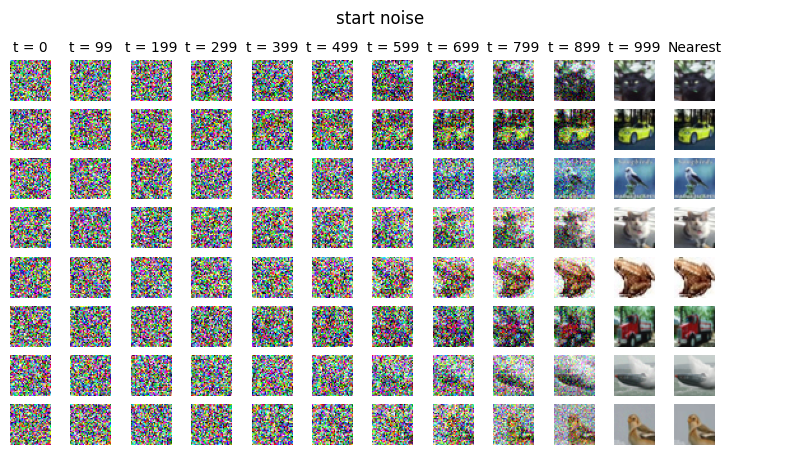

In [7]:
args = Namespace(
    sde_version='vp',
    device=4,
    timesteps=1000,
    start='noise',
    batchsize=8,
    temperature=1.0,
    dataset='1k')
weights = set_weights(args)
sde = reverse_sde(args, weights)

images = sde.p_sample_loop(return_all_time_steps=True)
fig, axes, dis = show_images(images, args, sde)

Text(0, 0.5, 'Density')

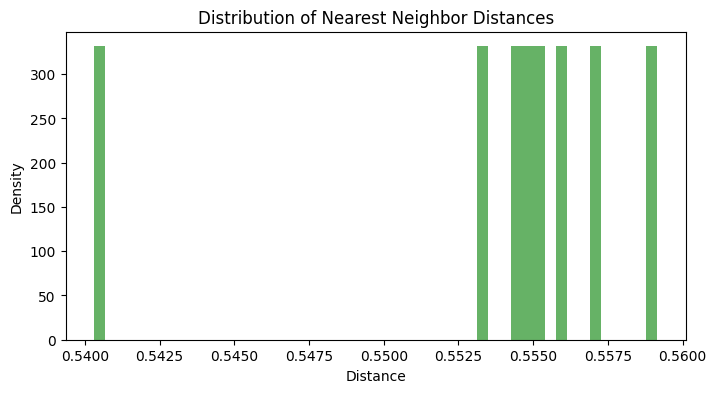

In [13]:
d = dis.cpu().detach().numpy()
# 绘制d的分布图
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(d, bins=50, density=True, alpha=0.6, color='g')
plt.title('Distribution of Nearest Neighbor Distances')
plt.xlabel('Distance')
plt.ylabel('Density')

In [5]:
# save fig
fig.savefig(f'sampling_{args.sde_version}_{args.start}_{args.dataset}.png', dpi=300, bbox_inches='tight')

### 2. x_xtart : image saved noise

Using device: cuda:4


sampling loop time step:   4%|▍         | 45/1000 [00:00<00:06, 146.57it/s]

sampling loop time step: 100%|██████████| 1000/1000 [00:06<00:00, 149.10it/s]


tensor([0.5629, 0.5568, 0.5607, 0.5532, 0.5560, 0.5505, 0.5554, 0.5497],
       device='cuda:4')


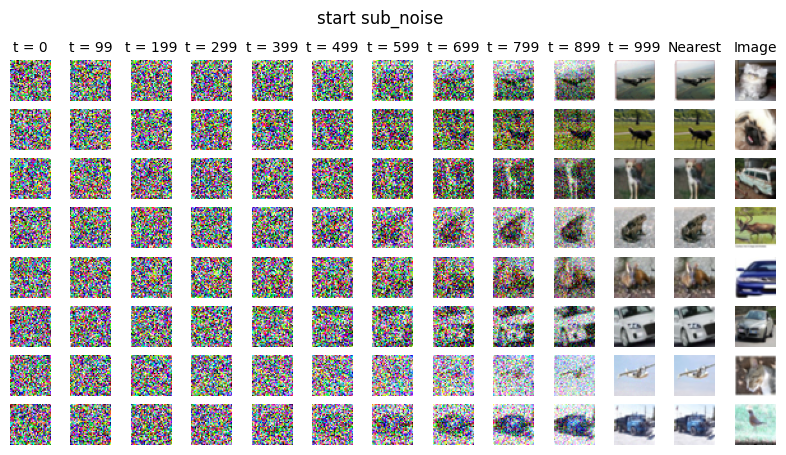

In [5]:
args = Namespace(
    sde_version='vp',
    device=4,
    timesteps=1000,
    start='sub_noise',
    batchsize=8,
    temperature=1.0,
    dataset='5k')
weights = set_weights(args)
sde = reverse_sde(args, weights)

images = sde.p_sample_loop(return_all_time_steps=True)
show_images(images, args, sde)

### 3. nearest image in the dataset

In [29]:
import torch

def find_nearest_neighbors_manual(query_images, database_images):
    """
    使用 PyTorch 广播机制手动计算最近邻。
    
    参数:
    query_images (torch.Tensor): 查询图片张量，维度 (n, C, H, W)
    database_images (torch.Tensor): 数据库图片张量，维度 (m, C, H, W)

    返回:
    tuple: (最近邻的距离, 最近邻的索引)
    """
    # 1. 扩展维度以启用广播
    # query_images: (n, C, H, W) -> (n, 1, C, H, W)
    # database_images: (m, C, H, W) -> (1, m, C, H, W)
    q = query_images.unsqueeze(1)
    d = database_images.unsqueeze(0)
    
    # 广播会使两个张量都扩展到 (n, m, C, H, W) 的维度进行相减
    # 2. 计算L2距离的平方
    # (q - d)**2 计算每个像素差的平方
    # .sum() 对 C, H, W 维度求和，得到每对图片间的距离平方
    dist_sq = torch.sum((q - d) ** 2, dim=(2, 3, 4))
    
    # 3. 计算L2距离
    dist_matrix = torch.sqrt(dist_sq) # 维度是 (n, m)

    # 4. 寻找最小值和索引
    nearest_distances, nearest_indices = torch.min(dist_matrix, dim=1)
    
    return nearest_distances, nearest_indices

dis, indices = find_nearest_neighbors_manual(images[-1].to(sde.device), sde.images)

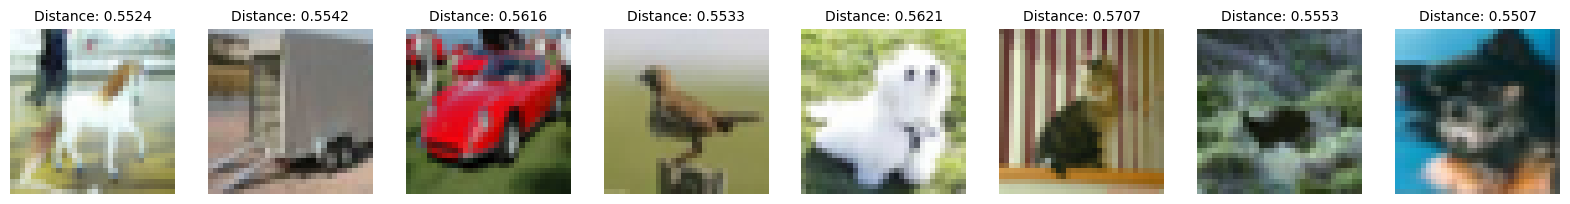

In [30]:
neighbors = sde.images[indices]
neighbors = normalize(neighbors)   
# show neighbors
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 8, figsize=(20, 5))
for i in range(8):
    ax = axes[i]
    ax.imshow(neighbors[i].transpose(1, 2, 0))
    ax.axis('off')
    ax.set_title(f"Distance: {dis[i]:.4f}", fontsize=10)
plt.show()